<a href="https://colab.research.google.com/github/harshy105/Uni_luebeck/blob/main/MDL_Exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDL Exercise 1

---

In this tutorial we will set up the foundations to load the data, create a fully-convolutional network (FCN) for image segmentation, and train it to solve multi-class segmentation problems for medical applications. On top of that, we will implement DeepLab with a MobileNetV2 backbone which will be compared to the results of the FCN.

**Data**

At first we download and unzip the data:

In [ ]:
!wget https://cloud.imi.uni-luebeck.de/s/zFyEiJKNtaKKzS8/download -O AbdomenPreAffine.zip
!unzip -o AbdomenPreAffine.zip > /dev/null  # disable the output

--2021-04-21 12:55:06--  https://cloud.imi.uni-luebeck.de/s/zFyEiJKNtaKKzS8/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1134479629 (1.1G) [application/zip]
Saving to: ‘AbdomenPreAffine.zip’

AbdomenPreAffine.zi 100%[===================>]   1.06G  18.7MB/s    in 59s     

2021-04-21 12:56:06 (18.5 MB/s) - ‘AbdomenPreAffine.zip’ saved [1134479629/1134479629]



In [ ]:
!wget https://cloud.imi.uni-luebeck.de/s/Fd63J7xMLmkMEzb/download -O mdl_exercise1_utils.py

from mdl_exercise1_utils import init_weights, Plotter, ZeroPad, Crop, Scale, ToCuda

--2021-04-21 13:04:44--  https://cloud.imi.uni-luebeck.de/s/Fd63J7xMLmkMEzb/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4256 (4.2K) [text/x-python]
Saving to: ‘mdl_exercise1_utils.py’

mdl_exercise1_utils 100%[===================>]   4.16K  --.-KB/s    in 0s      

2021-04-21 13:04:45 (568 MB/s) - ‘mdl_exercise1_utils.py’ saved [4256/4256]



Let's get started with the code and run all the imports:

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from tqdm import tqdm_notebook as tqdm

import nibabel as nib
import os
from collections import OrderedDict
from typing import Callable, Any, Optional, List

import matplotlib.pyplot as plt

The **training data** is loaded from the filesystem as:

In [ ]:
imgs2 = torch.randn(20,1,128,128,128).cuda()#/500
segs2 = torch.randint(1,(20,128,128,128)).long().cuda()
list_train = torch.Tensor([2,3,4,5,7,8,10,21,22,24,25,27,28,30,31,33,34,36,37,39,40])
list_test = torch.Tensor([1,4,7,10,23,26,29,32,35,38]).long()
for i in range(20):
    img = nib.load('/content/AbdomenPreAffine/Training/img/img00'+str(int(list_train[i])).zfill(2)+'.nii.gz').get_fdata()
    imgs2[i:i+1] = F.interpolate(torch.from_numpy(img).cuda().unsqueeze(0).unsqueeze(1).float(),size=(128,128,128),mode='trilinear').cuda()/500
    seg = nib.load('/content/AbdomenPreAffine/Training/label/label00'+str(int(list_train[i])).zfill(2)+'.nii.gz').get_fdata()
    segs2[i] = F.interpolate(torch.from_numpy(seg).cuda().unsqueeze(0).unsqueeze(1).float(),size=(128,128,128),mode='nearest').squeeze().cuda().long()
    print('Loaded', i+1, '/',20)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Loaded 1 / 20
Loaded 2 / 20
Loaded 3 / 20
Loaded 4 / 20
Loaded 5 / 20
Loaded 6 / 20
Loaded 7 / 20
Loaded 8 / 20
Loaded 9 / 20
Loaded 10 / 20
Loaded 11 / 20
Loaded 12 / 20
Loaded 13 / 20
Loaded 14 / 20
Loaded 15 / 20
Loaded 16 / 20
Loaded 17 / 20
Loaded 18 / 20
Loaded 19 / 20
Loaded 20 / 20


The **validation data** is loaded from the filesystem as:

In [ ]:
imgs_val = torch.randn(10,1,128,128,128).cuda()#/500
segs_val = torch.randint(2,(10,128,128,128)).long().cuda()
for i in range(10):
    img = nib.load('/content/AbdomenPreAffine/Training/img/img00'+str(int(list_test[i])).zfill(2)+'.nii.gz').get_fdata()
    imgs_val[i:i+1] = F.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(1).float(),size=(128,128,128),mode='trilinear').cuda()/500
    seg = nib.load('/content/AbdomenPreAffine/Training/label/label00'+str(int(list_test[i])).zfill(2)+'.nii.gz').get_fdata()
    segs_val[i] = F.interpolate(torch.from_numpy(seg).unsqueeze(0).unsqueeze(1).float(),size=(128,128,128),mode='nearest').squeeze().cuda().long()
    print('Loaded', i+1, '/',10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Loaded 1 / 10
Loaded 2 / 10
Loaded 3 / 10
Loaded 4 / 10
Loaded 5 / 10
Loaded 6 / 10
Loaded 7 / 10
Loaded 8 / 10
Loaded 9 / 10
Loaded 10 / 10


In [ ]:
segs2 = segs2.unsqueeze(1)
segs_val = segs_val.unsqueeze(1)

All data is being loaded now, thus we can start with the implementation of the following tasks.

---

**Task 1 (3 points)**: Now you can write your own implementation for an affine augmentation using the `nn.functional` package (already imported in the first cell as `F.`):

✔ Define random offsets added to an affine identity matrix

✔ Transform the matrix to a PyTorch grid using `F.affine_grid()`

✔ Resample image and label using `F.grid_sample()`

In [ ]:
class AugmentAffine(object):
  def __init__(self, strength=0.05):
    self.strength = strength

  def __call__(self, sample):
    B, C, D, H, W = sample# TODO access image data
    
    offsets = 0.001 # TODO random offsets
    
    affine_matrix = (torch.eye(3,4).unsqueeze(0) + self.strength * offsets)  
    affine_matrix.cuda()

    meshgrid = F.affine_grid(affine_matrix,sample.size())# TODO resampling grid

    sample['image'] = F.grid_sample(sample['image'],affine_matrix)# TODO resample image
    sample['label'] = F.grid_sample(sample['label'],affine_matrix)# TODO resample label
    
    return sample
augmentation_training = [AugmentAffine(0.1), ToCuda()]
augmentation_validate = [ToCuda()]

In [ ]:
print(torch.eye(3,4).unsqueeze(0) + 0.005)

tensor([[[1.0050, 0.0050, 0.0050, 0.0050],
         [0.0050, 1.0050, 0.0050, 0.0050],
         [0.0050, 0.0050, 1.0050, 0.0050]]])


---


**Task 2 (7 Points)**: Define a simplified Fully-Convolutional Network (FCN) architecture:

✔ Use double 3x3 convolutional blocks, such as in `block0`

✔ 3 poolings, and 1 final upsampling

✔ Double the channel number, half the spatial resolution

✔ To keep it easy: Use padding, so size of feature map after convolution is same as before



In [ ]:
class Net(nn.Module):
  def __init__(self, unet=True):
    super().__init__()
    #input[20,1,128,128,128]
    self.block0 = nn.Sequential(nn.BatchNorm3d(1),
                                nn.Conv3d(1, 16, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(16),
                                nn.Conv3d(16, 16, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.mp01 = nn.MaxPool3d(2, 2)

    # TODO add two more blocks and two more 2x2 poolings
    self.block1 = nn.Sequential(nn.BatchNorm3d(16),
                                nn.Conv3d(16,32,3,padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(32),
                                nn.Conv3d(32,32,3,padding=1),
                                nn.ReLU()
                                )
    self.mp02 = nn.MaxPool3d(2,2)

    self.block2 = nn.Sequential(nn.BatchNorm3d(32),
                                nn.Conv3d(32,64,3,padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(64),
                                nn.Conv3d(64,64,3,padding=1),
                                nn.ReLU()
                                )
    self.mp03 = nn.MaxPool3d(2,2)
 #output[20,64,16,16,16]
  
    # TODO add final classifiation block (1x1 convs instead of linear layers)
    self.upsample = nn.Sequential(nn.Conv3d(64,32,1),
                                  nn.ReLU(),
                                  nn.Conv3d(32,1,1),
                                  nn.Sigmoid(),
                                  )
    
    #output [20,1,128,128,128]
    
    
  def forward(self, inputs):
    output0 = self.block0(inputs)
    output1 = self.mp01(output0)
    output2 = self.block1(output1)
    output3 = self.mp02(output2)
    output4 = self.block2(output3)
    output5 = self.mp03(output4)
    
    # TODO Add forwards
    
    return F.interpolate(self.upsample(output5), scale_factor= 8)  # TODO Add both values

Let's set up the experiment.

First, we need the network model (`net`). The network weights need to be initialized with weights near 1 to avoid vanishing/exploding gradients issues that can later slow down the learning process.

Training of neural networks is an optimsation process. Thus, we further need:

1.  Parameters of a model to be optimized: ```net.parameters()```
2.  Optimization criterion: ```nn.BCELoss``` (binary cross-entropy)
3.  Optimizer adapting parameters of (1.) in order to minimize loss (2.): ```torch.optim.Adam```

One hyper-parameter of such gradient-descent optimisation is the number of iterations:

1.  Number of epochs: ```n_epochs``` (one epoch: processing all training sample batches once)

After the set up, we just run the main training routine and watch the loss going down!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


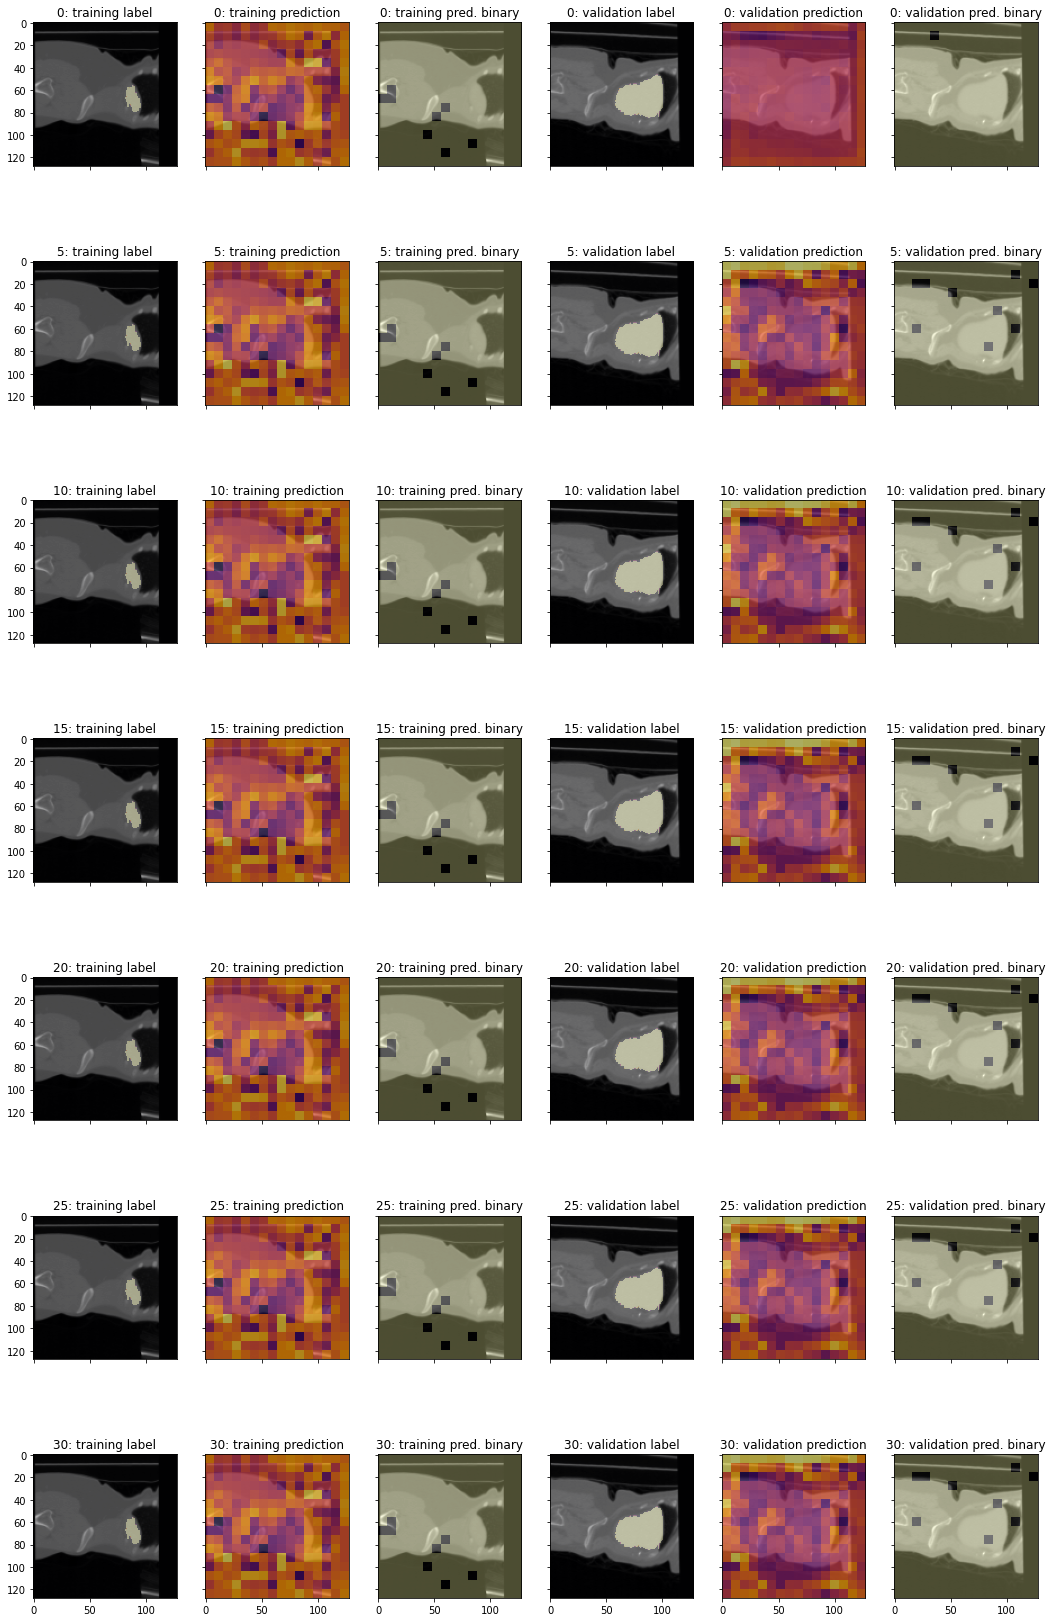

In [ ]:
# Hyper-parameters
n_epochs = 31

# Visualise progress every 5th epoch
every_epoch = 5
bin_thresh = 0.3
plotter = Plotter(n_epochs//every_epoch, z_slice=23, bin_thresh=bin_thresh)

# Network initialisation
net = Net(False).cuda()
net.apply(init_weights)

# Set up optimisation for training process
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# Save loss of each epoch
losses_training = []
losses_validate = []

# Show current progress and loss
progress = tqdm(range(n_epochs), desc='progress')

# making dict

data = {
  "image": imgs2,
  "label": segs2,
}

data_val = {
  "image": imgs_val,
  "label": segs_val,
}

######################
# MAIN TRAINING LOOP #
######################

for epoch in progress:
  
  ########################################
  #               TRAINING               #
  ########################################

  sum_loss = 0
  
  # Parameters must be trainable
  net.train()
  with torch.set_grad_enabled(True):  # TODO add bool value
    
    # loop to process all training samples (packed into batches)
    for i in range(20):# TODO draw training sample
      
      result = net.forward(data['image'][i].unsqueeze(0))# TODO forward run with sample

      loss =  criterion(result, data['label'][i].unsqueeze(0).float())# TODO compute BCE loss

      # TODO backward step to compute gradients for optimising the model weights

      sum_loss += loss.item()
  
  losses_training.append(sum_loss / len(list_train))# TODO add number of training samples)

  if epoch % every_epoch == 0:
    plotter.add_training_sample(data, result, epoch)
  
  
  ########################################
  #              VALIDATION              #
  ########################################

  sum_loss = 0
  
  # Parameters must not be trainable
  net.eval()
  with torch.set_grad_enabled(False):  # TODO add bool value
    
    # loop to process all validation samples (packed into batches)
    for i in range(10):# TODO draw validation sample
      
      # TODO copy and paste the lines required from the training step
      result = net.forward(data_val['image'][i].unsqueeze(0))# TODO forward run with sample

      loss =  criterion(result,data_val['label'][i].unsqueeze(0).float())# TODO compute BCE loss
      
      sum_loss += loss.item()
  
  losses_validate.append(sum_loss / len(list_test))# TODO add number of validation samples))
  
  if epoch % every_epoch == 0:
    plotter.add_validation_sample(data_val, result, epoch)
  
  progress.set_postfix(loss=losses_training[-1], val_loss=losses_validate[-1])

Let's first check if training has converged. We plot the loss over all training epochs.

Thus, we compare the training and validation loss curves:

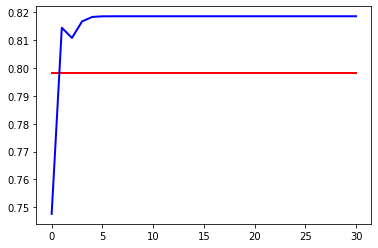

In [ ]:
plt.plot(losses_training, 'r-', linewidth=2)  # training loss in red
plt.plot(losses_validate, 'b-', linewidth=2)  # validation loss in blue

Reaching a plateau means, we can hopefully roughly see the segmentation matching the ground truth mask.

The following plot rows have been generated every fifth epoch:

In [ ]:
def dice_val(f_label, m_label):
  numerator = 2.0*torch.sum(f_label.view(-1) * m_label.view(-1))
  denominator = torch.sum(f_label.view(-1)) + torch.sum(m_label.view(-1))
  return numerator / denominator

sum_dice = 0
net.train(False)
with torch.set_grad_enabled(False):
  for i in range(10):# TODO draw validation sample
    result = net(data_val['image'][i].unsqueeze(0))  # forward run
    sum_dice += float(dice_val((result > bin_thresh).float(), data_val['label'][i].unsqueeze(0).float()))
print('Dice validation:', sum_dice/len(list_test))

Dice validation: 0.44963082671165466


**Task 3 (4 Points)**: Define the MobileNetV2 architecture

✔ Implement a linear bottleneck module

✔ Implement a inverted residual block

Please have a look at this paper https://arxiv.org/abs/1801.04381 and the exercise slides for reference.



At first we implement the **bottleneck module** for MobileNet:

In [ ]:
class ConvBNActivation(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        activation_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = # TODO set required layer
        if activation_layer is None:
            activation_layer = # TODO set required layer
        super(ConvBNReLU, self).__init__(
            # TODO add Conv3d
            norm_layer(out_planes),
            activation_layer(inplace=True)
        )
        self.out_channels = out_planes

# necessary for backwards compatibility
ConvBNReLU = ConvBNActivation

# helper function
def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

Implement the **inverted residual block** for MobileNet:

In [ ]:
class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = # TODO set required layer

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # TODO add the just generated bottleneck relu (Set appropriate kernel size & input dimension)
            # layers.append(ConvBNReLU(...))
        layers.extend([
            # TODO add the just generated bottleneck relu (What is the input dimension here?)
            # ConvBNReLU(...),
            # TODO add conv3d
            # ...
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self.is_strided = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            # TODO add return for residual 
            # return ... 
        else:
            # TODO add alternative return 
            # return ... 


Now we have all preliminaries for defining the **MobileNetV2** utilizing our previoulsy implemented residual and bottleneck modules: 

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = # TODO add required layer 

        if norm_layer is None:
            norm_layer = # TODO add required layer 

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                # TODO complete residual setup 
                # ...
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # build the first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        
        features: List[nn.Module] = # add bottleneck module
        
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(# TODO add settings for block))
                input_channel = output_channel
        
        # building last several layers
        features.append(# ...) # TODO add bottleneck
        
        self.features = # TODO make it nn.Sequential

        # TODO building classifier
        self.classifier = nn.Sequential(
            # TODO add a dropout
            # ... 
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    # This is a helper function bypassing forward due to restrictions in inheritance
    def _forward_impl(self, x: Tensor) -> Tensor:
        x = # TODO set to input features

        # TODO use adaptive average pooling on x (Hint: Use reshape)
        x = # ...
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

# setup mobilenet
def mobile3dnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV2:
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


**Task 4 (6 Points)**: Implement ASPP

✔ Implement the ASPPConv block defined as a 3x3 convolution followed by BatchNorm3d and ReLU

✔ Implement the ASPPPooling block consisting of a AdaptiveAvgPool3d followed by Conv3d, BatchNorm3d and ReLU blocks

✔ Setup ASPP with atrous rates of 2, 4, 8 and 16

✔ Train your DeepLabV3 network with MobileNetV2 as backbone 

✔ Evaluate, visualize and compare the results to the FCN’s output

Please also have a look at the paper https://arxiv.org/pdf/1706.05587.pdf and exercise slides.


Implement the **ASPP convolutional** as well as the **ASPP pooling** blocks as follows:

In [ ]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            # TODO add conv3d, batchnorm and relu modules (Remember setting the dilation)
            # ...
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            # TODO add conv3d, batchnorm and relu modules
            # ...

    def forward(self, x):
        size = # set the size of x
        x = # TODO use adaptive average pooling
        for mod in self:
            x = mod(x)
        # TODO finish this, use nearest neighbour interpolation)
        return F.interpolate(#...)

Now we can define **ASPP** while making use of ASPPConv and ASPPPooling blocks:

In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            # TODO add conv3d, batchnorm and relu modules
            # ...

        rates = tuple(atrous_rates)
        for rate in rates:
            # TODO add ASPPConv blocks with corresponding atrous rate 
            modules.append(# ...)
        
        # TODO add ASPPPooling
        modules.append(# ...)

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            # TODO add conv3d, batchnorm, relu & a final dropout
            # ...

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        # TODO concatenate res
        res = # ...
        return self.project(res)

We define our **DeepLabV3** network utilizing **ASPP** with the MobileNetV2 serving as our backbone:

In [ ]:
# initialize backbone feature extractor (MobileNet)
backbone = mobile3dnet(width_mult=0.75).features[:11]

backbone[0][0].weight.data = backbone[0][0].weight.data[:,:1]
backbone[0][0].in_channels = 1

# TODO set stride for corresponding layer 
backbone[4].conv[1][0].stride = # ...

for i in range(5,7):
    # TODO set dilatin and padding for corresponding layers
    backbone[i].conv[1][0].dilation = # ...
    backbone[i].conv[1][0].padding = # ...

# TODO add stride
backbone[7].conv[1][0].stride = # ...

for i in range(8,11):
  # TODO set dilatin and padding for corresponding layers
    backbone[i].conv[1][0].dilation = # ...
    backbone[i].conv[1][0].padding = # ...

# TODO initialize ASPP with correct atrious rates    
aspp = ASPP(# ...)
x = torch.randn(2,1,96,96,96)

num_classes = 14
head = nn.Sequential(nn.Conv3d(64, 64, 3, padding=1, bias=False),nn.BatchNorm3d(64),nn.ReLU(),\
                     nn.Conv3d(64, num_classes, 1))

In [ ]:
# init backbone, ASPP and the head
backbone.cuda()
aspp.cuda()
head.cuda()

# TODO setup an Adam optimizer
# Hint: You can read the required parameters from backbone/aspp as with the parameters() function 
optimizer = # ...

# A scaler is being used 
scaler = torch.cuda.amp.GradScaler()
import time
t0 = time.time()
run_loss = torch.zeros(100) 
for i in range(0, 10):
    idx = torch.randperm(20)[:4]
    optimizer.zero_grad()

    with torch.no_grad():
        # TODO add affine augmentation
        affine = F.affine_grid(# ...)
        input = F.grid_sample(imgs2[idx],affine,padding_mode='border')
        target = F.grid_sample(segs2[idx].float().unsqueeze(1),affine,mode='nearest').squeeze(1).long()
    with torch.cuda.amp.autocast():
        # TODO read x as output of head (subsequent to aspp and backbone)
        x = # ...
        # TODO upscale x by factor of 4 using trinilear interpolation
        output = # ...
        # TODO add cross entropy loss 
        loss = # ...

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    # Updates the scale for next iteration.
    scaler.update()

    run_loss[i] = loss.item()

    if(i % 10 == 0):
        print(i,time.time()-t0,'sec','loss',run_loss[i-8:i-1].mean())

Plot the loss:

In [ ]:
plt.plot(torch.log(F.avg_pool1d(run_loss.view(1,1,-1),15,stride=1).squeeze()));
plt.show()

Run the **validation**:

In [ ]:
def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

# validation
head.eval()
backbone.eval()
aspp.eval()

d_all = torch.zeros(10,13)
predict_all = torch.zeros(10,128,128,128).short()
for i in range(10):
    with torch.no_grad():
        # TODO read x from head (having passed aspp & backbone)
        x = # ...
        # TODO upscale x by factor of 4 
        output = # ...
    
    predict_all[i] = output.argmax(1).cpu().data
    d = dice_coeff(output.argmax(1).cpu().data,segs_val[i:i+1].cpu().data,14)
    
    d_all[i,:] = d
  
label_txt = ['spleen','right kidney','left kidney','esophagus','liver','stomach','inferior vena cava',\
             'portal vein','pancreas']

label_rgb = torch.Tensor([0,0,0, 208,0,0, 255,230,2, 48,194,0, 0,0,0, 0,110,255, 98,0,190, 247,0,255, 158,97,0, 255,160,70, \
                         0,131,32, 49,165,171]).view(12,3)


Inspect the **loss** and **dice** for the invidual classes:

In [ ]:
# TODO evaluation

The following function can be used to overlay the predicted segmentation onto the input images:

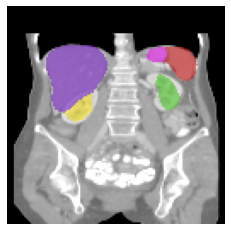

In [ ]:
def overlaySegment(gray1,seg1,colors,flag=False):
    H, W = seg1.squeeze().size()
    segs1 = F.one_hot(seg1.long(),14).float().permute(2,0,1)[:12] 

    seg_color = torch.mm(segs1.view(12,-1).t(),colors[:12,:]).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy()); 
        plt.axis('off');
        plt.show()
    return overlay

y = 57
gray = torch.clamp(imgs_val[1,0,:,y,:].t().flip(0).data.cpu()+4/5,0,7/5)*5/7
rgb = overlaySegment(gray,predict_all[1,:,y,:].t().flip(0).float(),label_rgb/255,True)

# TODO Visualize multiple images with corresponding overlays
# ...


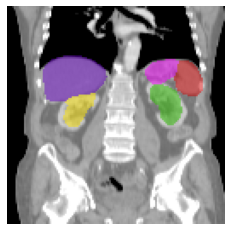

In [ ]:
y = 57
gray = torch.clamp(imgs_val[5,0,:,y,:].t().flip(0).data.cpu()+4/5,0,7/5)*5/7
rgb = overlaySegment(gray,predict_all[5,:,y,:].t().flip(0).float(),label_rgb/255,True)



**Bonus** Use a dice as a loss function and inspect the results:

In [ ]:
# ...